# Deep Vision Project by Fabian Schmidt
####  Who is allowed to enter the classroom: Contrastive Learning for face and signature recognition

<a id="0"></a>
 # Table of Contents
1. [Preparing the Dataset](#1)     
    - [Download Datasets](#1a)
    - [Define Custom Dataset class](#1b)
    - [Define Train-Test-Split](#1c)
    - [Print positive and negative Sample](#1d)
2. [Define Model](#2)


## Preparing the Dataset<a class="anchor" id="1"></a>

#### Download UTKFace and signature-verification Dataset<a class="anchor" id="1a">

In [ ]:
import opendatasets as od 
import pandas 

#!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip
#!unzip UTKFace.zip -d data && rm UTKFace.zip
#!rm -rf __MACOSX/
#!rm -rf data/__MACOSX

  
od.download("https://www.kaggle.com/datasets/mallapraveen/signature-matching/data") 

!mv signature-matching/custom signature
!rmdir signature-matching/
!mv signature data

In [ ]:
!unzip data/att.zip

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.Image 

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

#### Define Custom Dataset classes<a class="anchor" id="1b">

##### Face Dataset<a class="anchor" id="1b">

In [2]:
class FaceNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look until the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look until a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [3]:
# Load the training dataset
face_train_folder_dataset = datasets.ImageFolder(root="./data/faces/training/")
face_test_folder_dataset = datasets.ImageFolder(root="./data/faces/testing/")


# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])


# Initialize the network
face_train_dataset = FaceNetworkDataset(imageFolderDataset=face_train_folder_dataset, transform=transformation)

train_size = int(0.8 * len(face_train_dataset))
valid_size = len(face_train_dataset) - train_size
face_train_dataset, face_valid_dataset = torch.utils.data.random_split(face_train_dataset, [train_size, valid_size])

face_test_dataset = FaceNetworkDataset(imageFolderDataset=face_test_folder_dataset, transform=transformation)

print(f"Number of training samples: {len(face_train_dataset)}")
print(f"Number of validation samples: {len(face_valid_dataset)}")
print(f"Number of testing samples: {len(face_test_dataset)}")


Number of training samples: 296
Number of validation samples: 74
Number of testing samples: 30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.78039217].


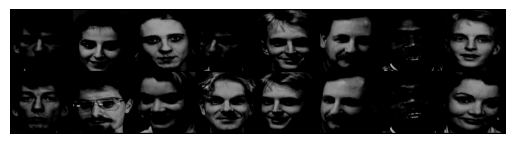

[0. 1. 1. 1. 0. 0. 0. 1.]


In [4]:
# Create a dataloader just visualization
vis_dataloader = DataLoader(face_valid_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

##### Signature Dataset<a class="anchor" id="1b">

In [5]:
import pandas as pd
import os
import PIL
class SignatureNetworkDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):        
        self.transform = transform
        self.root_dir = root_dir
        self.data = df

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img0_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        img1_name = os.path.join(self.root_dir, self.data.iloc[idx, 1])
        image0 = Image.open(img0_name)
        image1 = Image.open(img1_name)
        
        image0 = image0.convert("L")
        image1 = image1.convert("L")

        if self.transform:
            image0 = self.transform(image0)
            image1 = self.transform(image1)

        return image0, image1, torch.from_numpy(np.array([int(self.data.iloc[idx, 2])], dtype=np.float32))
        
    def __len__(self):
        return len(self.data)

In [6]:
from sklearn.model_selection import train_test_split
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

signature_train_csv = "./data/signature/train_data.csv"
signature_test_csv = "./data/signature/test_data.csv"
signature_image_dir = "./data/signature/full"

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])

signature_train_df = pd.read_csv(signature_train_csv)
signature_test_df = pd.read_csv(signature_test_csv)
train_df, valid_df = train_test_split(signature_train_df, test_size=0.2,random_state = 42)

# Initialize the network
siamese_dataset = FaceNetworkDataset(imageFolderDataset=folder_dataset, transform=transformation)

signature_train_dataset = SignatureNetworkDataset(df=train_df, root_dir=signature_image_dir, transform=transformation)
signature_valid_dataset = SignatureNetworkDataset(df=valid_df, root_dir=signature_image_dir, transform=transformation)
signature_test_dataset = SignatureNetworkDataset(df=signature_test_df, root_dir=signature_image_dir, transform=transformation)

print(f"Number of training samples: {len(signature_train_dataset)}")
print(f"Number of validation samples: {len(signature_valid_dataset)}")
print(f"Number of testing samples: {len(signature_test_dataset)}")

Number of training samples: 61376
Number of validation samples: 15345
Number of testing samples: 8525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42745095..1.0].


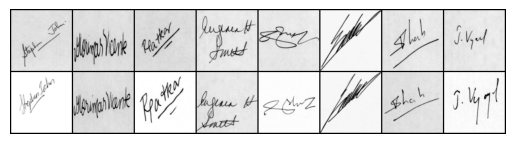

[0. 1. 0. 1. 0. 1. 1. 0.]


In [7]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(signature_train_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

[Back to the top](#0) 

## Define Model<a class="anchor" id="2">

In [8]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=5.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      # label = 1 means different people, label = 0 means same people  
      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

Epoch number 0
 Current loss 12.577844619750977

Validation loss after 10 iterations: 11.716249465942383

Epoch number 1
 Current loss 11.052506446838379

Validation loss after 20 iterations: 9.88810920715332

Epoch number 2
 Current loss 9.157644271850586

Validation loss after 30 iterations: 7.698665618896484

Epoch number 3
 Current loss 4.751471519470215

Validation loss after 40 iterations: 5.489536285400391

Epoch number 4
 Current loss 4.567827224731445

Validation loss after 50 iterations: 4.839021682739258

Epoch number 5
 Current loss 3.6386916637420654

Validation loss after 60 iterations: 3.347723960876465

Epoch number 6
 Current loss 3.1415181159973145

Validation loss after 70 iterations: 4.648601055145264

Epoch number 7
 Current loss 3.8159589767456055

Validation loss after 80 iterations: 3.7857959270477295

Epoch number 8
 Current loss 3.1023330688476562

Validation loss after 90 iterations: 3.5623767375946045

Epoch number 9
 Current loss 3.0429487228393555

Validat

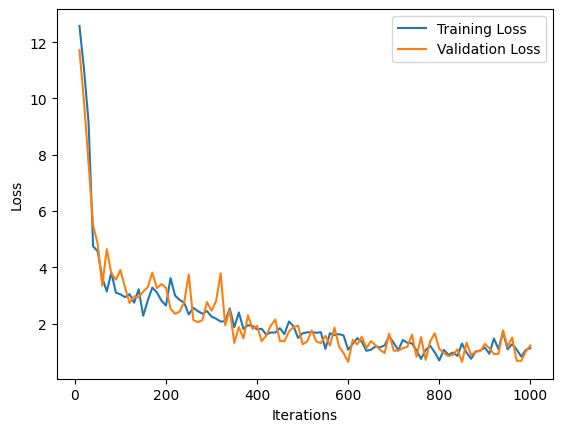

Test loss: 2.132636070251465


In [9]:
import SiameseFaceNetwork
# Load the training dataset
face_train_loader = DataLoader(face_train_dataset, shuffle=True, num_workers=8, batch_size=256)
face_valid_loader = DataLoader(face_valid_dataset, shuffle=True, num_workers=8, batch_size=256)
face_test_loader = DataLoader(face_test_dataset, shuffle=True, num_workers=8, batch_size=256)

face_net = SiameseFaceNetwork.SiameseFaceNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(face_net.parameters(), lr = 0.0005 )
face_net.train_network(train_loader = face_train_loader, val_loader = face_valid_loader, net = face_net, optimizer = optimizer, criterion = criterion, epochs = 100)

test_loss = face_net.evaluate_test(face_test_loader, face_net, criterion)

In [16]:

torch.save(face_net.state_dict(), 'checkpoints/face_net.pt')




Epoch number 0
 Current loss 0.7991228103637695

Validation loss after 10 iterations: 0.7199039340019227

Epoch number 0
 Current loss 0.696016252040863

Validation loss after 20 iterations: 0.6943832238515218

Epoch number 0
 Current loss 0.6939385533332825

Validation loss after 30 iterations: 0.6945062398910522

Epoch number 0
 Current loss 0.6923729777336121

Validation loss after 40 iterations: 0.69065021276474

Epoch number 0
 Current loss 0.6792590022087097

Validation loss after 50 iterations: 0.6823359330495199

Epoch number 0
 Current loss 0.6531344056129456

Validation loss after 60 iterations: 0.6594253977139791

Epoch number 1
 Current loss 0.8302479386329651

Validation loss after 70 iterations: 0.7044579744338989

Epoch number 1
 Current loss 0.6950135231018066

Validation loss after 80 iterations: 0.6953856348991394

Epoch number 1
 Current loss 0.6960995197296143

Validation loss after 90 iterations: 0.6953522880872091

Epoch number 1
 Current loss 0.6965073347091675



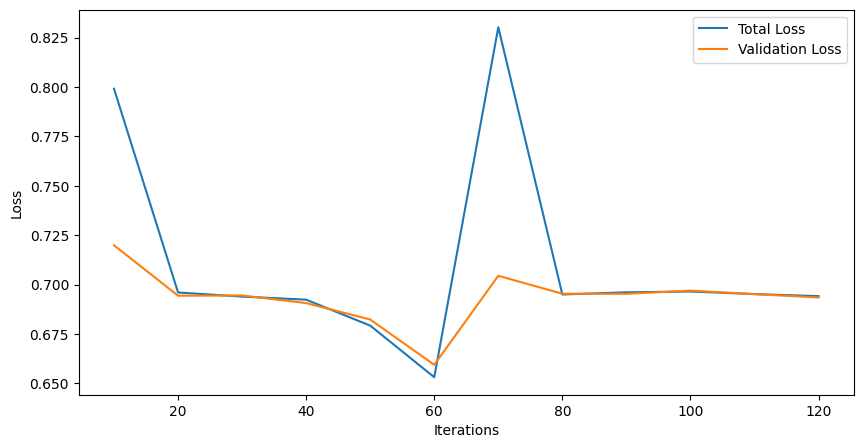

In [11]:
import MultitaskSignatureNet

signature_train_loader = DataLoader(signature_train_dataset, shuffle=True, num_workers=8, batch_size=1024)
signature_valid_loader = DataLoader(signature_valid_dataset, shuffle=True, num_workers=8, batch_size=1024)

signature_net = MultitaskSignatureNet.SignatureNet().cuda()
optimizer = optim.Adam(signature_net.parameters(), lr = 0.0005)
signature_net.train_network(signature_train_loader, signature_valid_loader, signature_net, optimizer, epochs=2)

In [17]:
torch.save(face_net.state_dict(), 'checkpoints/signature_net.pt')


In [14]:
signature_test_loader = DataLoader(signature_test_dataset, shuffle=True, num_workers=8, batch_size=128)

accuracy = signature_net.compute_accuracy(signature_test_loader, signature_net)
print(f"Forgery detection accuracy on the test dataset: {accuracy:.2f}%")

Forgery detection accuracy on the test dataset: 64.32%
